In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Class for a simple Linear classifier

In [3]:
# Now there are 9 classes, so 9 logits/output nodes

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=9):
        super(LinearClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x

### Synthetic data generation

In [4]:
class_frequencies = [32/80] + [16/80]*2 + [6/80]*2 + [1/80]*4
N = 2000

np.random.seed(2022)
covariance = np.identity(2) * 0.25
# A is the most dominant class, {B,C} are next most dominant class, then {D,E} then {F,G,H,I}
sampA = np.random.multivariate_normal([0,0], covariance, int(N*class_frequencies[0]))
sampB = np.random.multivariate_normal([0,2], covariance, int(N*class_frequencies[1]))
sampC = np.random.multivariate_normal([0,-2], covariance, int(N*class_frequencies[2]))
sampD = np.random.multivariate_normal([2,0], covariance, int(N*class_frequencies[3]))
sampE = np.random.multivariate_normal([-2,0], covariance, int(N*class_frequencies[4]))
sampF = np.random.multivariate_normal([-2,2], covariance, int(N*class_frequencies[5]))
sampG = np.random.multivariate_normal([2,2], covariance, int(N*class_frequencies[6]))
sampH = np.random.multivariate_normal([-2,-2], covariance, int(N*class_frequencies[7]))
sampI = np.random.multivariate_normal([2,-2], covariance, int(N*class_frequencies[8]))
np.random.seed()
X_values = np.concatenate((sampA, sampB, sampC, sampD, sampE, sampF, sampG, sampH, sampI), axis=0)
y_flat = np.array([])
for i in range(9):
    y_flat = np.concatenate((y_flat, np.array([i] * int(N*class_frequencies[i]))))

index_shuffle = np.arange(len(X_values))
np.random.shuffle(index_shuffle)

X_values = X_values[index_shuffle]
y_flat = y_flat[index_shuffle]

X_train = torch.tensor(X_values).type(torch.FloatTensor)
y_train = torch.from_numpy(y_flat).view(-1,1).type(torch.LongTensor)

#### Plots

##### This just shows how our training dataset.

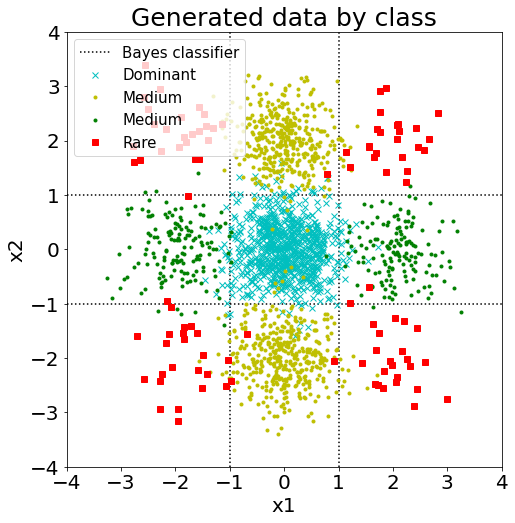

In [5]:
# Draw decision boundaries of the Bayes classifier
plt.axvline(x = 1, color='k', linestyle=':', label='Bayes classifier')
plt.axvline(x = -1, color='k', linestyle=':')
plt.axhline(y = 1, color='k', linestyle=':')
plt.axhline(y = -1, color='k', linestyle=':')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
# Plot the data
plt.plot(sampA[:,0], sampA[:,1], 'cx', label='Dominant')
plt.plot(sampB[:,0], sampB[:,1], '.y', label='Medium')
plt.plot(sampC[:,0], sampC[:,1], '.y')
plt.plot(sampD[:,0], sampD[:,1], '.g', label='Medium')
plt.plot(sampE[:,0], sampE[:,1], '.g')
plt.plot(sampF[:,0], sampF[:,1], 'sr', label='Rare')
plt.plot(sampG[:,0], sampG[:,1], 'sr')
plt.plot(sampH[:,0], sampH[:,1], 'sr')
plt.plot(sampI[:,0], sampI[:,1], 'sr')
# Formatting plot, adds title, axis labels, saves plot etc.
plt.title('Generated data by class', fontsize=25)
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.axis('scaled')
plt.axis([-4,4,-4,4])
figure = plt.gcf()
figure.set_size_inches(8,8)
plt.savefig('imbalMultiData', dpi=1500)
plt.show()

A mesh for visualising decision boundaries

In [6]:
# Creates a mesh of ~800^2 points in [-4,4]^2
x1_fit = np.linspace(-4,4,800)
x2_fit = np.linspace(-4,4,800)

mesh_grid = np.meshgrid(x1_fit, x2_fit)

X_mesh = np.hstack([mesh_grid[0].reshape(-1, 1), mesh_grid[1].reshape(-1, 1)]).astype(np.float32)
X_mesh = torch.from_numpy(X_mesh)

In [7]:
# Produces scatter plot, with Bayes classifier. Each point on the dense mesh is coloured by the predicted class

def mesh_plot(y_pred, title, fileName):
    plt.axvline(x = 1, color='k', linestyle=':')
    plt.axvline(x = -1, color='k', linestyle=':')
    plt.axhline(y = 1, color='k', linestyle=':')
    plt.axhline(y = -1, color='k', linestyle=':')
    plt.title(title, fontsize=25)
    y_pred_colours = [['c','y','y','g','g','r','r','r','r'][i] for i in y_pred.detach().numpy()]
    plt.scatter(X_mesh[:,0], X_mesh[:,1], c = y_pred_colours, marker='.')
    plt.xlabel('x1', fontsize=20)
    plt.ylabel('x2', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.axis('scaled')
    plt.axis([-4,4,-4,4])
    figure = plt.gcf()
    figure.set_size_inches(8,8)
    plt.savefig(fileName, dpi=800)
    plt.show()

#### Linear classifier

In [8]:
model_orig = LinearClassifier()

In [9]:
def modelTrain(model, optimizer, criterion):
    for epoch in range(50000):
        # zero the gradients
        optimizer.zero_grad()

        # forward
        output = model(X_train)
        loss = criterion(output, y_train.view(-1))
        
        # backward
        loss.backward()

        # optimise
        optimizer.step()

In [10]:
model_erm = deepcopy(model_orig)
criterion_erm = torch.nn.CrossEntropyLoss()
optimizer_erm = torch.optim.SGD(model_erm.parameters(), lr=0.01)

In [11]:
# trains model_erm under vanilla ERM with cross-entropy
modelTrain(model_erm, optimizer_erm, criterion_erm)

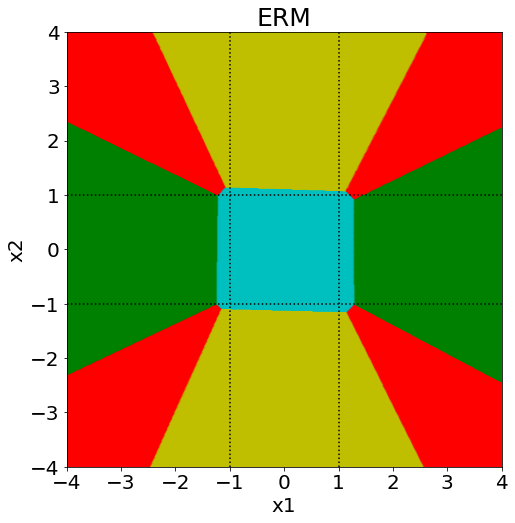

In [17]:
y_pred_erm = model_erm.forward(X_mesh)
y_pred_erm = torch.argmax(y_pred_erm, axis = 1)
mesh_plot(y_pred_erm, 'ERM', 'imbalMultiVanilla.png')

### Linear classifier with additive update

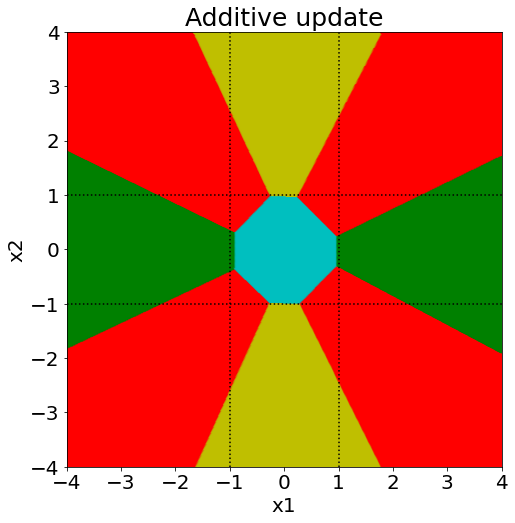

In [13]:
adjustments = torch.from_numpy(np.log(class_frequencies)).type(torch.FloatTensor)
# modified predictions with additive update
y_pred_adjusted = torch.argmax(model_erm.forward(X_mesh) - adjustments, axis = 1)
mesh_plot(y_pred_adjusted, 'Additive update', 'imbalMultiAdditive.png')

### Linear classifier with modified loss

In-built weighting of CrossEntropyLoss with weight argument in PyTorch. This gives the loss function as in Menon (4); corresponding to 'balancing' the loss.

In [14]:
model_w = deepcopy(model_orig)
optimizer_w = torch.optim.SGD(model_w.parameters(), lr=0.01)
# class-weight the cross-entropy
criterion_w = torch.nn.CrossEntropyLoss(weight = torch.tensor(np.reciprocal(class_frequencies)).type(torch.FloatTensor))

In [15]:
modelTrain(model_w, optimizer_w, criterion_w)

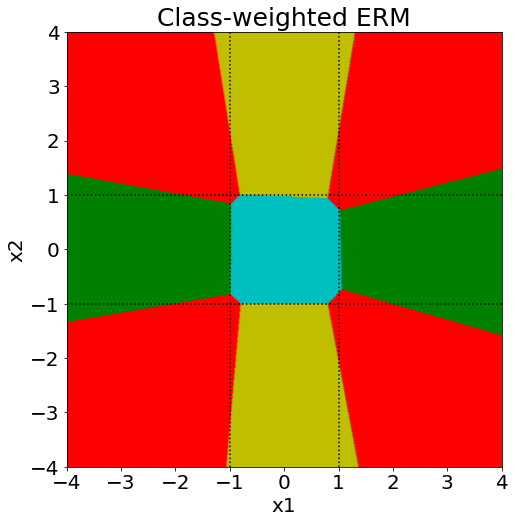

In [16]:
y_pred_w = model_w.forward(X_mesh)
y_pred_w = torch.argmax(y_pred_w, axis = 1)
mesh_plot(y_pred_w, 'Class-weighted ERM', 'imbalMultiWeighted.png')